In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy import io
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')


# For 3d plot
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
import itertools

# very limited information when exception is caught
%xmode Plain
# %pdb on or %ipdb on # enable debugger when exception occurred

Exception reporting mode: Plain


In [2]:
# https://stackoverflow.com/questions/47834140/numpy-equivalent-of-matlabs-magic
def magic_3(n):
    if n % 2 == 0:
        raise ValueError('n must be odd')
    return np.mod((np.arange(n)[:, None] + np.arange(n)) + (n-1)//2+1, n)*n + \
          np.mod((np.arange(1, n+1)[:, None] + 2*np.arange(n)), n) + 1


def magic_4x(n):
    if n % 4 != 0:
        raise ValueError('n must be a multiple of 4')
    M = np.empty([n, n], dtype=int)
    M[:, :n//2] = np.arange(1, n**2//2+1).reshape(-1, n).T
    M[:, n//2:] = np.flipud(M[:, :n//2]) + (n**2//2)
    M[1:n//2:2, :] = np.fliplr(M[1:n//2:2, :])
    M[n//2::2, :] = np.fliplr(M[n//2::2, :])
    return M

def magic_n(n):
  n = int(n)
  if n < 3:
    raise ValueError("Size must be at least 3")
  if n % 2 == 1:
    p = np.arange(1, n+1)
    return n*np.mod(p[:, None] + p - (n+3)//2, n) + np.mod(p[:, None] + 2*p-2, n) + 1
  elif n % 4 == 0:
    J = np.mod(np.arange(1, n+1), 4) // 2
    K = J[:, None] == J
    M = np.arange(1, n*n+1, n)[:, None] + np.arange(n)
    M[K] = n*n + 1 - M[K]
  else:
    p = n//2
    M = magic(p)
    M = np.block([[M, M+2*p*p], [M+3*p*p, M+p*p]])
    i = np.arange(p)
    k = (n-2)//4
    j = np.concatenate((np.arange(k), np.arange(n-k+1, n)))
    M[np.ix_(np.concatenate((i, i+p)), j)] = M[np.ix_(np.concatenate((i+p, i)), j)]
    M[np.ix_([k, k+p], [0, k])] = M[np.ix_([k+p, k], [0, k])]
  return M 

In [3]:
ex3data = io.loadmat(os.path.join('data', 'ex3data1.mat'))
X = ex3data['X']
y = ex3data['y']

X = np.insert(X, 0, 1, axis=1)

list(ex3data.keys()), X.shape, y.shape

(['__header__', '__version__', '__globals__', 'X', 'y'],
 (5000, 401),
 (5000, 1))

In [4]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [5]:
rand_indices = np.random.choice(y.size, 100, replace = False)
sel = X[rand_indices, :]
sel.shape

(100, 401)

In [6]:
def displayImg(X, example_width = None, figsize=(10, 10)):
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]
    else:
        raise IndexError('Input X should be 1 or 2 dimensional array')
    print('m = %s, n = %s' %(m, n))
    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = int(n / example_width)
    print('example_width = %s, example_height = %s' %(example_width, example_height))
          
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil( m / display_rows))
    print('d_rows = %s, s_cols = %s' %(display_rows, display_cols))
    
    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace = 0.025, hspace = 0.025)
    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_height, order = 'F'), cmap = 'Greys', extent = [0, 1, 0, 1])
        ax.axis('off')
    

m = 100, n = 400
example_width = 20, example_height = 20
d_rows = 10, s_cols = 10


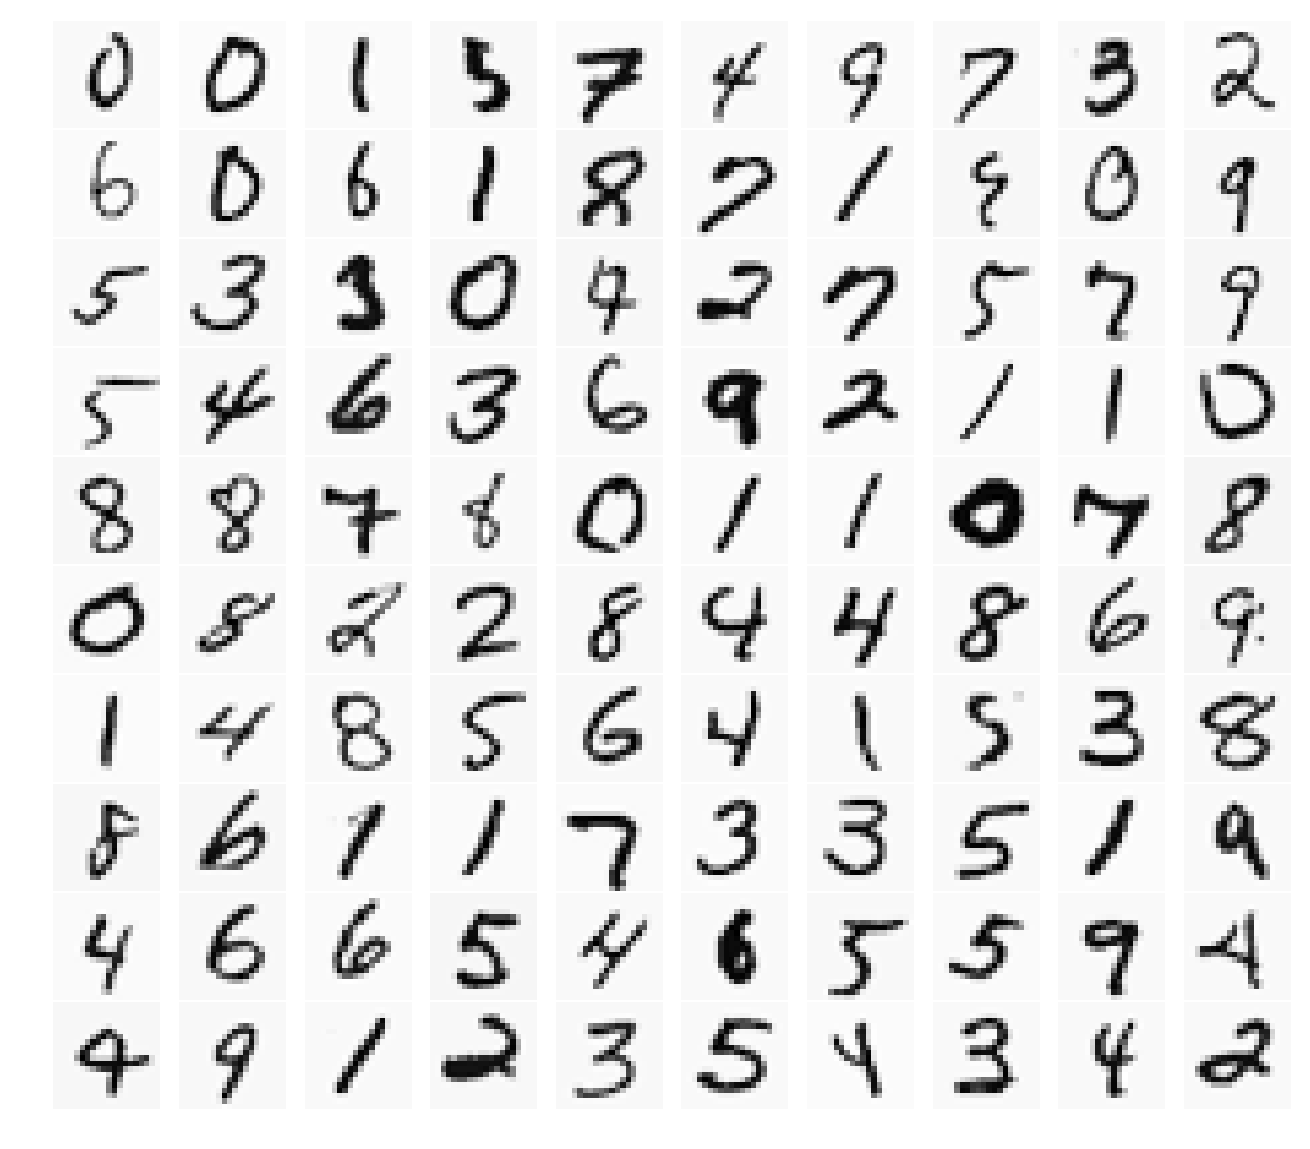

In [7]:
displayImg(sel[:, 1:]) # ingoring intercept term

In [8]:
theta_t = np.array([1, 2, 3 ,4], dtype=float)
print('{:.1f}, {:.1f}, {:.1f}, {:.1f}'.format(*theta_t))
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order = 'F')/10.0], axis=1)
print('{:.1f}, {:.1f}, {:.1f}, {:.1f}'.format(*X_t[1, :]))
y_t = np.array([1, 0, 1, 0, 1])
print('{:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.1f}'.format(*y_t))
lambda_t = 3

1.0, 2.0, 3.0, 4.0
1.0, 0.2, 0.7, 1.2
1.0, 0.0, 1.0, 0.0, 1.0


In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

In [10]:
sigmoid(0)

0.5

In [11]:
def cost(theta, X, y, lr):
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(theta)
    m = len(X)
    first = np.multiply(-y, np.log(sigmoid(np.dot(X,theta.T))))
    second = np.multiply((1-y), np.log((1-sigmoid(np.dot(X,theta.T)))))
    mean_first_second = (1/m) * np.sum(first - second) # without regularization
    reg_term = (lr/(2*m)) / np.sum(np.square(theta)) # calculate regularization
    cost_error = mean_first_second + reg_term # with regularization
    return cost_error

In [12]:
_X = magic_n(3)
_X = np.insert(_X, 0, 1, axis = 1)
_n = np.shape(_X)[1]
_limit = 1 / math.sqrt(_n)
#_theta = np.random.uniform(-_limit, _limit, (_n,)) 
_theta = np.array([-2, -1, 1, 2], dtype=float)
_y = np.array([1, 0, 1])
_X.shape, _theta.shape, _y.shape

((3, 4), (4,), (3,))

In [13]:
cost(_theta, _X, _y, 1)

8.0661663161813

In [14]:
n_features = np.shape(X)[1]
limit = 1 / math.sqrt(n_features)
theta = np.random.uniform(-limit, limit, (n_features,))
theta[1:5], theta.shape

(array([ 0.00646682, -0.01490982,  0.0016463 , -0.03492225]), (401,))

In [15]:
np.isnan(X).any()

False

In [16]:
cost(theta, X, y, 0)

-12.197197079379338

In [31]:
def gradient(theta, X, y, lr):
    theta = np.matrix(theta) # shape: (1, 4)
    J_theta = np.zeros(theta.shape[1])
    X = np.matrix(X) # shape: (3, 4)
    y = np.matrix(y) # shape: (1, 3)
    n_samples = np.shape(X)[0]
    h_x = sigmoid(X * theta.T) # shape: (3, 1)
    error = h_x - y.T #shape: (3, 1) (5000, 5000)
    sum_error_x0 = (1/n_samples) * np.sum(np.multiply(error, X[:, [0]]))
    J_theta[0] = sum_error_x0
    sum_error_xn = ((X[:, 1:].T * error) / n_samples).T
    sum_error_xn_lr = sum_error_xn + ((lr/n_samples) * theta[:, 1:])
    #print(sum_error_xn_lr)
    J_theta[1:] = sum_error_xn_lr
    return J_theta

In [32]:
gradient(_theta, _X, _y, 3) # (4, ), (3, 4), (3, )

(3, 1)


array([ 0.31722075, -0.12768456,  2.6481235 ,  4.23787228])

In [33]:
grad = gradient(theta, X, y, 1)
grad.shape

(5000, 5000)


ValueError: could not broadcast input array from shape (5000,400) into shape (400)

In [20]:
_X = magic_n(3)
_X = np.insert(_X, 0, 1, axis = 1)
_theta = np.array([-2, -1, 1, 2], dtype=float)
_y = np.array([1, 0, 1])
_X.shape, _theta.shape, _y.shape

((3, 4), (4,), (3,))

In [21]:
grad = gradient(_theta, _X, _y, 3)
grad.shape
print('{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*grad))

(4,)
(1, 4)
(3, 4)
(4, 1)


ValueError: could not broadcast input array from shape (3,3) into shape (3)